# Heart Attack Study
By Kai C, Nathaniel G, Josiah L, Joseph T

## Data Preprocessing

Since the dataset file is too large, we will download the csv file (https://www.kaggle.com/datasets/ankushpanday2/heart-attack-prediction-in-united-states) and keep it in the downloads folder.

We will then import pandas and read the csv file and convert it into a dataframe.

### Import Libraries:

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

### Read CSV file:

In [80]:
heart_attack_df = pd.read_csv('~/Downloads/heart_attack_dataset.csv')

### Remove Rows with NULL values:

In [81]:
heart_attack_df = heart_attack_df.dropna()

print("Rows: " + str(len(heart_attack_df.index)))


Rows: 372974


### Parsing:

Reassigned the value 1 to True and value 0 to False for the Smoker, Diabetes, Hypertension, FamilyHistory, PreviousHeartAttack, and StrokeHistory columns.

In [82]:
heart_attack_df['Smoker'] = heart_attack_df['Smoker'].apply(lambda value : True if value == 1 else False)
heart_attack_df['Diabetes'] = heart_attack_df['Diabetes'].apply(lambda value : True if value == 1 else False)
heart_attack_df['Hypertension'] = heart_attack_df['Hypertension'].apply(lambda value : True if value == 1 else False)
heart_attack_df['FamilyHistory'] = heart_attack_df['FamilyHistory'].apply(lambda value : True if value == 1 else False)
heart_attack_df['PreviousHeartAttack'] = heart_attack_df['PreviousHeartAttack'].apply(lambda value : True if value == 1 else False)
heart_attack_df['StrokeHistory'] = heart_attack_df['StrokeHistory'].apply(lambda value : True if value == 1 else False)

heart_attack_df.head()

,Age,Gender,Cholesterol,BloodPressure,HeartRate,BMI,Smoker,Diabetes,Hypertension,FamilyHistory,...,ExerciseInducedAngina,Slope,NumberOfMajorVessels,Thalassemia,PreviousHeartAttack,StrokeHistory,Residence,EmploymentStatus,MaritalStatus,Outcome
0,31,Male,194,162,71,22.9,False,True,False,False,...,Yes,Downsloping,1,Normal,False,False,Suburban,Retired,Single,No Heart Attack
1,69,Male,208,148,93,33.9,True,True,False,False,...,Yes,Upsloping,2,Normal,False,False,Suburban,Unemployed,Married,No Heart Attack
2,34,Female,132,161,94,34.0,False,False,True,True,...,Yes,Upsloping,0,Normal,True,False,Rural,Retired,Single,Heart Attack
3,53,Male,268,134,91,35.0,False,True,True,False,...,Yes,Flat,0,Reversible defect,True,False,Suburban,Retired,Widowed,No Heart Attack
4,57,Female,203,140,75,30.1,False,True,False,False,...,Yes,Flat,0,Fixed defect,True,False,Rural,Retired,Married,Heart Attack


## Conclusion 1
By Joseph

## Conclusion 2
By Josiah

I will write a two sided and two sample T test for my hypothesis test based on the independent groups of blood presssures of people that had a previous heart attack and blood pressures of people that did not have a previous heart attack. The alpha value will be 0.05.



- H0: There is no difference between the mean blood pressures of people that had a previous heart attack and the mean blood pressures of people that didn't have a previous heart attack.
- HA: There is a difference between the mean blood pressures of people that had a previous heart attack and the mean blood pressures of people that didn't have a previous heart attack.

If the ratio between the groups are less than 4:1 then we can consider the given groups to have equal variance.

In [88]:
previous_heart_attack = heart_attack_df[heart_attack_df['PreviousHeartAttack'] == True]['BloodPressure']
no_previous_heart_attack = heart_attack_df[heart_attack_df['PreviousHeartAttack'] == False]['BloodPressure']

print("Previous Heart Attack Variance: " + str(np.var(previous_heart_attack)))
print("No Previous Heart Attack Variance: " + str(np.var(no_previous_heart_attack)))

Previous Heart Attack Variance: 672.9307263333194
No Previous Heart Attack Variance: 677.4239673804153


The ratio 677.424:672.931 is less than the 4:1 ratio which allows us to assume a same variance.

In [89]:
# Two sided and two sample T test
stat, p_value = scipy.stats.ttest_ind(a=previous_heart_attack, b=no_previous_heart_attack, equal_var=True)

print("P Value: " + str(p_value))

P Value: 0.21653200354387594


The p-value of 0.217 > alpha value of 0.05, so we fail to reject the null hypothesis that there is no difference between the mean blood pressures of people that had a previous heart attack and the mean blood pressures of people that didn't have a previous heart attack.

Text(0, 0.5, 'Blood Pressure (mmHg)')

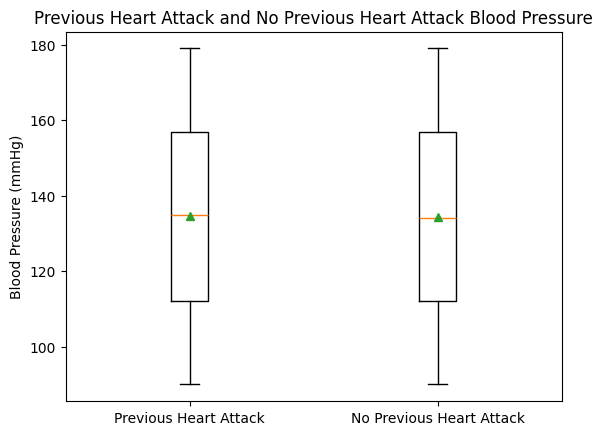

In [97]:
plt.boxplot([previous_heart_attack, no_previous_heart_attack], tick_labels=["Previous Heart Attack", "No Previous Heart Attack"], showmeans=True)
plt.title('Previous Heart Attack and No Previous Heart Attack Blood Pressure')
plt.ylabel('Blood Pressure (mmHg)')

This plots boxplots for the two groups. Note that the green triangles represent the mean and the red line represents the median.

## Conclusion 3
By Nathan

## Conclusion 4 (extra)
By Kai

I will write a new hypothesis test based on four categorical variables, thus, I will be using ANOVA tests.

The following is a hypothesis test for whether the marital status has an effect on the outcome of a heart attack. (Assume $\alpha=0.05$).

- HO: The marital status does not have an effect on the outcome of whether one has a heart attack (i.e., they're independent).

- HA: The martial status does have an effect on the outcome of whether one has a heart attack.

I will first split the data into 4 different dataframes based on marital status.

In [92]:
# to tell me what the categorical variables were
# heart_attack_df['MaritalStatus'].unique()

single = heart_attack_df['MaritalStatus'] == 'Single'
married = heart_attack_df['MaritalStatus'] == 'Married'
widowed = heart_attack_df['MaritalStatus'] == 'Widowed'
divorced = heart_attack_df['MaritalStatus'] == 'Divorced'

# store the proportions of 'No Heart Attack' and 'Heart Attack'
single_proportion = heart_attack_df[single]['Outcome'].value_counts(normalize=True)
married_proportion = heart_attack_df[married]['Outcome'].value_counts(normalize=True)
widowed_proportion = heart_attack_df[widowed]['Outcome'].value_counts(normalize=True)
divorced_proportion = heart_attack_df[divorced]['Outcome'].value_counts(normalize=True)

display([single_proportion, married_proportion, widowed_proportion, divorced_proportion])

[Outcome
 No Heart Attack    0.500347
 Heart Attack       0.499653
 Name: proportion, dtype: float64,
 Outcome
 Heart Attack       0.500894
 No Heart Attack    0.499106
 Name: proportion, dtype: float64,
 Outcome
 No Heart Attack    0.501075
 Heart Attack       0.498925
 Name: proportion, dtype: float64,
 Outcome
 No Heart Attack    0.5013
 Heart Attack       0.4987
 Name: proportion, dtype: float64]

Next, I will use an ANOVA test called the one-way ANOVA test, which tests the null hypothesis that two or more groups have the same population proportion, and will have the test yield a p-value.

This hypothesis test is one of the only ways to test multiple categorical variables.

In [93]:
# ANOVA test
anova_test = scipy.stats.f_oneway(single, married, widowed, divorced)

anova_test.pvalue

np.float64(0.1399070014962428)

I will create a bar chart to show the relationship between marital status and the outcome of whether one has a heart attack.

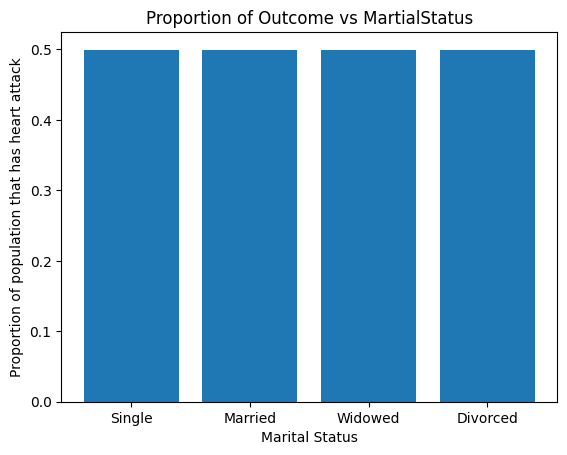

In [94]:
x_var = np.array(['Single', 'Married', 'Widowed', 'Divorced'])
y_var = np.array([single_proportion.iloc[1], married_proportion.iloc[1], widowed_proportion.iloc[1], divorced_proportion.iloc[1]])

plt.bar(x_var, y_var)
plt.title('Proportion of Outcome vs MartialStatus')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of population that has heart attack')
plt.show()

Since the p-value = 0.14 > (alpha = 0.05), we fail to reject the null hypothesis.